### The face mask classfication problem in VGGs with Lightning

1. To build VGG 16 with pretrained model.
2. Changing number of classes to 2 for dataset of chandrikadeb7/Face-Mask-Detection.
3. Classifying image from http.

In [4]:
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git
!pip install -qqq pytorch_lightning
!pip install -qqq torchsummary
!pip install -qqq livelossplot

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 4590, done.
remote: Total 4590 (delta 0), reused 0 (delta 0), pack-reused 4590 (from 1)
Receiving objects: 100% (4590/4590), 186.72 MiB | 45.42 MiB/s, done.
Resolving deltas: 100% (271/271), done.
Updating files: 100% (4155/4155), done.


In [35]:
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
import logging
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torchvision.models import vgg16, vgg19
from torchsummary import summary
from PIL import Image
import warnings
warnings.filterwarnings("ignore", ".*Palette images with Transparency.*")

1. Data load, and divided into train, validation and test  
2. Using the horizontal flip and rotation as random in train dataset.
3. To avoid random_split in order to apply different transform.

In [7]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transform
])

dataset_path = "Face-Mask-Detection/dataset"
train_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)
dataset = datasets.ImageFolder(dataset_path, transform=transform)

In [8]:
def load_data():
    # use dataset with different transform, instead of train, val, test = torch.utils.data.random_split(dataset, [l, r, r]).
    
    l=len(dataset) 
    indices = list(range(l))
    r = (int)(l*0.17)
    l -= r<<1
    r += l
    
    np.random.shuffle(indices)
    train_idx, val_idx, test_idx = indices[:l], indices[l:r], indices[r:]
    # print(f'[{l}], [{l}:{r}], [{r}:]')

    train = Subset(train_dataset, indices=train_idx)
    val = Subset(dataset, indices=val_idx)
    test = Subset(dataset, indices=test_idx)

    batch_size = 64
    num_workers = 2
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=num_workers)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data()
print(f'train: {len(train_loader.dataset)}, valid: {len(val_loader.dataset)}, test: {len(test_loader.dataset)}')

train: 2704, valid: 695, test: 695


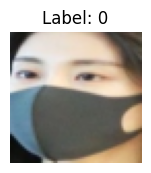

In [154]:
def _show_one(images, labels):
    to_pil = transforms.ToPILImage()
    fig = plt.figure(figsize=(16,16))
    for i, (image, label) in list(enumerate(zip(images, labels)))[:1]:
        image_pil = to_pil(image)
        sub = fig.add_subplot(8, 1, i+1)
        sub.set_title(f'Label: {label}')
        plt.axis('off')
        plt.imshow(image_pil)

images, labels = next(iter(val_loader))
_show_one(images, labels)
    

To build pretrained model with VGG16 and VGG19, and freezes layers from the second to last of max pooling.

In [ ]:
def load_model(name):
    model, l = (vgg19(weights=torchvision.models.VGG19_Weights.IMAGENET1K_V1), -9) if name == 'vgg19' else (vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1), -7)
    for p in model.features[:l]: p.require_grad = False
    in_features = model.classifier[0].out_features
    model.classifier[-4] = nn.Linear(in_features, 512)
    model.classifier[-1] = nn.Linear(512, 2)    
    # for i, m in enumerate(model.children()): 
    #     if i==2: print(f'{i}. {m}')
    return model
# model = load_model('vgg19')
# summary(model,(3,224,224))

Appling ReduceLROnPlateau, Momentum, EarlyStopping and ModelCheckpoint.

In [65]:
class FaceMaskClassifier(pl.LightningModule):
    def __init__(self, model_name="vgg19", num_classes=2, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.model = load_model(model_name)
        self.criterion = nn.CrossEntropyLoss()
        self.test_acc = []
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.validate(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss
 
    @torch.no_grad()
    def validate(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1)==y).float().mean()
        return loss, acc

    def test_step(self, batch, batch_idx):
        loss, acc = self.validate(batch)
        self.test_acc += [acc.cpu().numpy()]
        return loss, acc
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.1,patience=3,verbose=True)
        return {"optimizer": optimizer,"lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss", "frequency": 1, "strict": True}}
    
    def evaluate(self):
        return np.array(self.test_acc).mean()
        
def _fit(model_name):
    print(f"{model_name}:")
    max_epochs = 20
    mcp = pl.callbacks.ModelCheckpoint(monitor="val_loss", dirpath=f"checkpoints/{model_name}", save_top_k=1, mode="min")
    es = pl.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=True, mode="min")
    rpb = pl.callbacks.RichProgressBar()
    tb = pl.loggers.TensorBoardLogger(save_dir=f"logs/1/{model_name}", name=None)
    model = FaceMaskClassifier(model_name=model_name, num_classes=2, lr=1e-3)
    trainer = pl.Trainer(max_epochs=max_epochs,log_every_n_steps=10, logger=tb, callbacks=[rpb, es, mcp], verbose=False)
    trainer.fit(model, train_loader, val_loader)
    trainer.test(model, dataloaders=test_loader)
    acc = model.evaluate()
    print(f"Test Accuracy: {acc:.4f}")
    return model

In [38]:
model_vgg19 = _fit('vgg19')

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 0:00:01 • 0:00:00 6.54it/s

Test Accuracy: 0.9943


In [66]:
model_vgg16 = _fit('vgg16')

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 0:00:01 • 0:00:00 6.92it/s

Test Accuracy: 0.9957


Image classify from http.

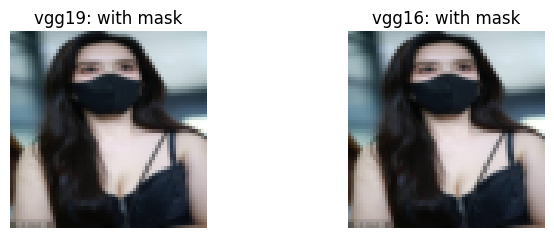

In [156]:
from PIL import Image
import requests
from io import BytesIO

def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def _comparing(images, labels, model_name=None):
    labels_text = ['with mask', "without mask"]
    to_pil = transforms.ToPILImage()
    fig = plt.figure(figsize=(16,24))
    for i, (image, label, model) in list(enumerate(zip(images, labels, model_name)))[:2]:
        image_pil = to_pil(image)
        sub = fig.add_subplot(8, i+1, 1)
        sub.set_title(f'{model}: {labels_text[label]}')
        plt.axis('off')
        plt.imshow(image_pil)

img = load_image('https://na.cx/i/eqzQJYw.jpg')
x = transform(img).unsqueeze(0)

model_vgg19.eval()
vgg19_y = model_vgg19(img_tensor)

model_vgg16.eval()
vgg16_y = model_vgg16(img_tensor)

_comparing([x.squeeze(0),x.squeeze(0)], [torch.argmax(vgg16_y, dim=1), torch.argmax(vgg19_y, dim=1)], ['vgg16', 'vgg19'])


https://www.kaggle.com/discussions/general/151033

In [ ]:
%load_ext tensorboard
%tensorboard --logdir_spec=vgg16:logs/vgg16/version_0,vgg19:logs/vgg19/version_0